In [1]:
# + проверить выкидывание групп
# + сначала разбить, потом обработать
# + catboost

# neuron

# reg 2 classification


import gc

gc.enable()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import lightgbm as lgb

import os
import os.path
# print(os.listdir("../input"))

# credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
by_team = ['matchId','groupId']

In [3]:
random_seed = 15305
df_train = None

if not os.path.isfile('train_V2_solo.csv'):
    print('Solo file not exists, load all')
    df_train = pd.read_csv('train_V2.csv')
    df_train = reduce_mem_usage(df_train)
    df_train = df_train[df_train['winPlacePerc'].isna() != True]
    mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
    
#     df_train['matchType'].value_counts().plot.bar()
    
    df_train['matchType'] = df_train['matchType'].apply(mapper)
    
    old_size = df_train.shape[0]
    
    df_train = df_train[df_train['matchType'] == 'solo']
    
    print('Reduced size from ', old_size, ' to ', df_train.shape[0])
    
    df_train.to_csv('train_V2_solo.csv', index=False)
    
else:
    df_train = pd.read_csv('train_V2_solo.csv')
    df_train = reduce_mem_usage(df_train)
    print('Solo file exists, loaded, size: ', df_train.shape[0])
        

gc.collect()

Solo file exists, loaded, size:  720712


7

In [4]:
df_train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.062236,0.297540,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.059862,1.799456,0.0,0.000000,0.000000,2.000000,28.0
damageDealt,NaN,NaN,0.0,0.000000,74.375000,169.250000,6616.0
DBNOs,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
headshotKills,0.249281,0.660425,0.0,0.000000,0.000000,0.000000,42.0
heals,1.014149,2.406086,0.0,0.000000,0.000000,1.000000,63.0
killPlace,47.457529,27.728956,1.0,23.000000,47.000000,71.000000,100.0
killPoints,447.426431,594.989089,0.0,0.000000,0.000000,1090.000000,1970.0
kills,0.936860,1.603249,0.0,0.000000,0.000000,1.000000,66.0
killStreaks,0.475054,0.564241,0.0,0.000000,0.000000,1.000000,18.0


In [5]:
# none of null, inf columns
null_columns=df_train.columns[df_train.isin([np.Inf, np.NINF, np.nan]).any()]
df_train[null_columns].isnull().sum()

Series([], dtype: float64)

In [6]:
df_train.drop('DBNOs',  axis =1,inplace= True)
df_train.drop('revives',  axis =1,inplace= True)

In [46]:
df_train['maxPlace'].describe()

count    720712.000000
mean         93.908900
std          10.134818
min           2.000000
25%          94.000000
50%          96.000000
75%          97.000000
max         100.000000
Name: maxPlace, dtype: float64

In [13]:
# from sklearn.preprocessing import MinMaxScaler

def feature_engineering(df, is_train=True):
    test_idx = None
    if not is_train: 
        print("processing test")
        test_idx = df.Id
    else:
        print("processing train")
    

    
    print("remove some columns")
    target = 'winPlacePerc'
    

    print("Adding Features")
    
    df['headshotrate'] = df['kills']/df['headshotKills']
    df['killStreakrate'] = df['killStreaks']/df['kills']
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df['skill'] = df['headshotKills'] + df['roadKills']
    
    df['totalTimeByDistance'] = df['rideDistance'] / float(5) + df['walkDistance'] + df['swimDistance'] * float(5)
    
    df['zombi'] = ((df['totalDistance'] == 0) & (df['kills'] == 0)
                     & (df['weaponsAcquired'] == 0)).astype(int)
    df['cheater'] = ((df['kills'] / df['totalDistance'] >= 1)
                       | (df['kills'] > 30) | (df['roadKills'] > 10)).astype(int)

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
      
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(by_team)[target].agg('mean'), dtype=np.float64)
    
    features.remove(target)

    print("get group mean feature")
    agg = df.groupby(by_team)[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[by_team]
    else: df_out = df[by_team]
    
    
    

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=by_team)

    
    
    # Важные фичы, поскольку оказывается группа может быть больше 1, хотя соло
    
#     print("get group sum feature")
#     agg = df.groupby(by_team)[features].agg('sum')
#     agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
#     df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
#     df_out = df_out.merge(agg_rank, suffixes=["_sum", "_sum_rank"], how='left', on=by_team)
    
    print("get group max feature")
    agg = df.groupby(by_team)[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=by_team)
    
    print("get group min feature")
    agg = df.groupby(by_team)[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=by_team)
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=by_team)
    
    
    print("get group size feature")
    agg = df.groupby(by_team).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=by_team)
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(by_team, axis=1, inplace=True)

#     scaler = MinMaxScaler()
#     scaler.fit(df_out)
    X = df_out #scaler.transform(df_out)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

In [14]:
# X, y, columns, _ = feature_engineering(df_train, True)
# X = reduce_mem_usage(X)

In [15]:
import random
random.seed(random_seed)
# ухудшает, потому что этим надо разбивать изначально,а не только обучение

def train_test_split_match(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    train_y = train['winPlacePerc']
    test_y = test['winPlacePerc']
    
#     train.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
#     test.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
    
    return train, test, train_y, test_y

In [16]:
# X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1,
# random_state=random_seed)

import warnings
warnings.filterwarnings("ignore")

# X_train, X_holdout, y_train, y_holdout = train_test_split(df_train, df_train['winPlacePerc'], test_size=0.1,
# random_state=random_seed)

X_train, X_holdout, y_train, y_holdout = train_test_split_match(df_train, test_size=0.1)


X_train, y_train, columns, _ = feature_engineering(X_train, True)
X_train = reduce_mem_usage(X_train)


X_holdout, _, _ ,_ = feature_engineering(X_holdout, False)

# Да, я тоже тут не прав
train_index = round(int(X_train.shape[0]*0.9))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y_train[:train_index] 
val_y = y_train[train_index:] 
gc.collect()

gc.collect()
print(dev_X.shape, val_X.shape)

processing train
remove some columns
Adding Features
Removing Na's From DF
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
processing test
remove some columns
Adding Features
Removing Na's From DF
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
(561836, 254) (62427, 254)


In [34]:
print(X_train.shape, X_holdout.shape)

(624263, 254) (72107, 254)


In [35]:



model_name = 'lgb_model_long.txt'

def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000,
              'early_stopping_rounds':500,#300
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.9,#0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.9#0.7
             }
    model = None
    
    if not os.path.isfile(model_name):
        print(model_name, ' not found, start train ;-(')
        lgtrain = lgb.Dataset(train_X, label=train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], verbose_eval=1000)
        model.save_model(model_name)
        
    else:
        print(model_name, ' found, start predict ;-)')
        model = lgb.Booster(model_file=model_name)
        
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()

lgb_model_long.txt  not found, start train ;-(
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 0.0277705	valid_1's l1: 0.0296699
[2000]	training's l1: 0.0259441	valid_1's l1: 0.0292298
[3000]	training's l1: 0.0246271	valid_1's l1: 0.0290882
[4000]	training's l1: 0.0235468	valid_1's l1: 0.029037
[5000]	training's l1: 0.0225958	valid_1's l1: 0.0290037
Early stopping, best iteration is:
[5388]	training's l1: 0.0222635	valid_1's l1: 0.0289968


226

In [36]:
pred_y = pred_test.copy()
df_sub = X_holdout.copy()
gc.collect()
df_sub.head()

,assists_mean,boosts_mean,damageDealt_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,longestKill_mean,...,headshotKills_over_kills,distance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,killsPerWalkDistance,skill,totalTimeByDistance,zombi,cheater,match_size
0,0.0,1.0,324.250000,1.0,5.0,5.0,986.0,4.0,1.0,49.84375,...,0.097652,429.908020,247.75,395.00,0.001689,0.237113,1389.0,0.030928,0.0,97
1,0.0,3.0,254.250000,0.0,12.0,13.0,0.0,2.0,1.0,36.00000,...,0.045015,255.876892,273.75,300.50,0.003794,0.177083,919.0,0.020833,0.0,96
2,0.0,0.0,17.812500,0.0,0.0,79.0,1274.0,0.0,0.0,0.00000,...,0.104545,672.716797,370.00,442.25,0.000844,0.272727,1705.0,0.040404,0.0,99
3,0.0,0.0,25.921875,0.0,0.0,86.0,0.0,0.0,0.0,0.00000,...,0.135690,254.033783,264.75,323.75,0.003582,0.268041,852.5,0.041237,0.0,97
4,0.0,1.0,200.000000,1.0,2.0,22.0,0.0,2.0,1.0,15.84375,...,0.104340,227.767334,269.75,276.25,0.002224,0.239583,764.0,0.031250,0.0,96


In [38]:
print("MAE: ",
mean_absolute_error(y_holdout, pred_y) )

print("MSE: ",
mean_squared_error(y_holdout, pred_y))

MAE:  0.02856782848780568
MSE:  0.0017420440541760455


MAE:  0.02856782848780568
MSE:  0.0017420440541760455

MAE:  0.04148302305808674
MSE:  0.003809335695206919

In [39]:
def fix_pred(X, pred):
    df_sub = X.copy()
    df_sub['winPlacePerc'] = pred
    df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
    df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1
    df_sub.loc[(df_sub['maxPlace'] > 1) & (df_sub['numGroups'] == 1), 'winPlacePerc'] = 0
    subset = df_sub.loc[df_sub.maxPlace > 1]
    gap = 1.0 / (subset.maxPlace.values - 1)
    new_perc = np.around(subset.winPlacePerc.values / gap) * gap
    df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
    return df_sub["winPlacePerc"]

light_fix_pred = fix_pred(df_sub, pred_test)

print("MAE: ",
mean_absolute_error(y_holdout, light_fix_pred) )

print("MSE: ",
mean_squared_error(y_holdout, light_fix_pred))

MAE:  0.028296510609863976
MSE:  0.0017524940919096165


MAE:  0.04126190270820107
MSE:  0.00381583213713465

In [57]:
fi = model.feature_importance(importance_type='gain')
fn = model.feature_name()
fi = fi / fi.max() * 100

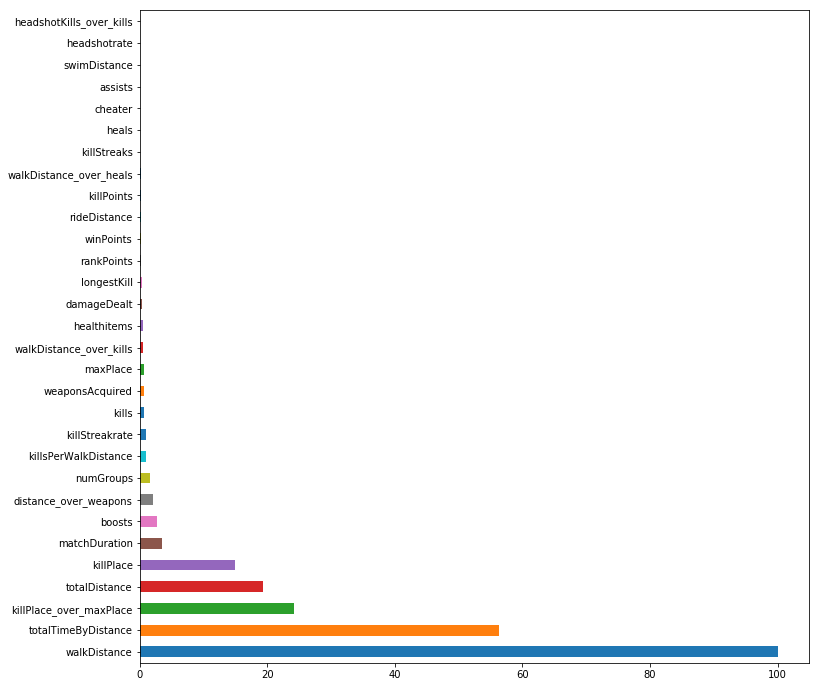

In [58]:
feat_importances = pd.Series(fi, index=fn)
feat_importances.nlargest(30).plot(kind='barh', figsize=(12,12))

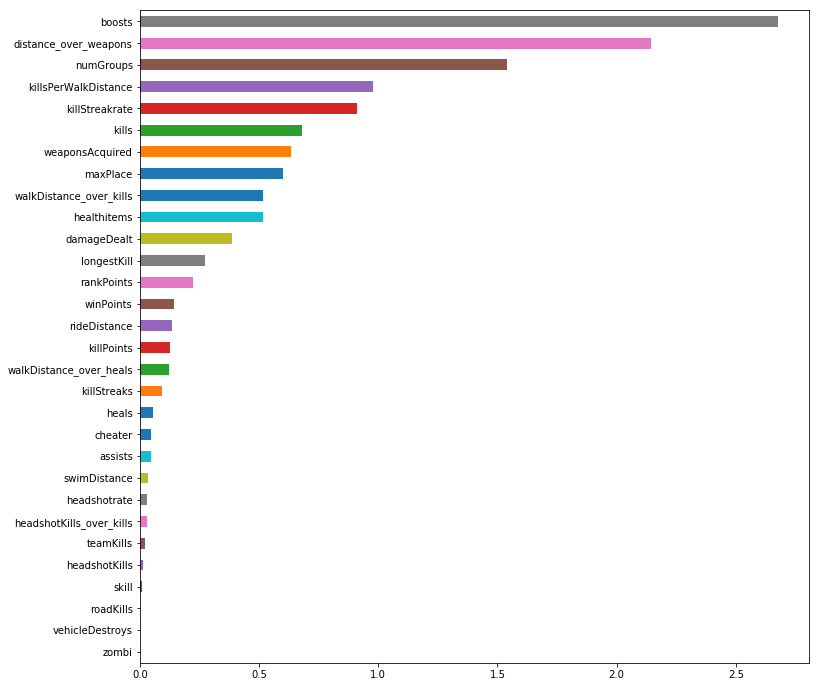

In [59]:
feat_importances.nsmallest(30).plot(kind='barh', figsize=(12,12))

# Test CatBoost

In [35]:
import catboost
from catboost import CatBoostRegressor

cat_model_name = 'new_cat_model.txt'
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = None
    
    
    
    if not os.path.isfile(cat_model_name):
        print(cat_model_name, ' not found, start train ;-(')
        model = CatBoostRegressor(iterations=1500,
                             learning_rate=0.05,
                             depth=13,
                             eval_metric='MAE',
                              
                             bootstrap_type='Bayesian',
                             bagging_temperature = 0.4,
                             colsample_bylevel=0.9,

                             od_type='Iter',

                             od_wait=20)
        model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False)
        model.save_model(cat_model_name)
        
    else:
        print(cat_model_name, ' found, start predict ;-)')
        model = CatBoostRegressor()
        model.load_model(cat_model_name)
    
    
    
    
    y_pred_submit = model.predict(X_test)

    return y_pred_submit, model

In [36]:
cat_preds, cat_model = run_catboost(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()


new_cat_model.txt  found, start predict ;-)


0

In [37]:
print("MAE: ",
mean_absolute_error(y_holdout, cat_preds) )

print("MSE: ",
mean_squared_error(y_holdout, cat_preds))

MAE:  0.03930947714587424
MSE:  0.003449869912570009


In [ ]:
MAE:  0.03930947714587424
MSE:  0.003449869912570009
    
MAE:  0.03935530079373704
MSE:  0.003452247054532898
    
MAE:  0.03937937994147074
MSE:  0.003442165049903201
    
MAE:  0.03985730187929903
MSE:  0.0035289553600514898
    
MAE:  0.039967249401811435
MSE:  0.0035292414797628764
    
MAE:  0.040002110668519705
MSE:  0.0035109118428077045
    
MAE:  0.04018625081067348
MSE:  0.0035448821657998275

In [64]:
cat_fi = cat_model.get_feature_importance(fstr_type='FeatureImportance')
cat_fn = cat_model.feature_names_
cat_fi = cat_fi


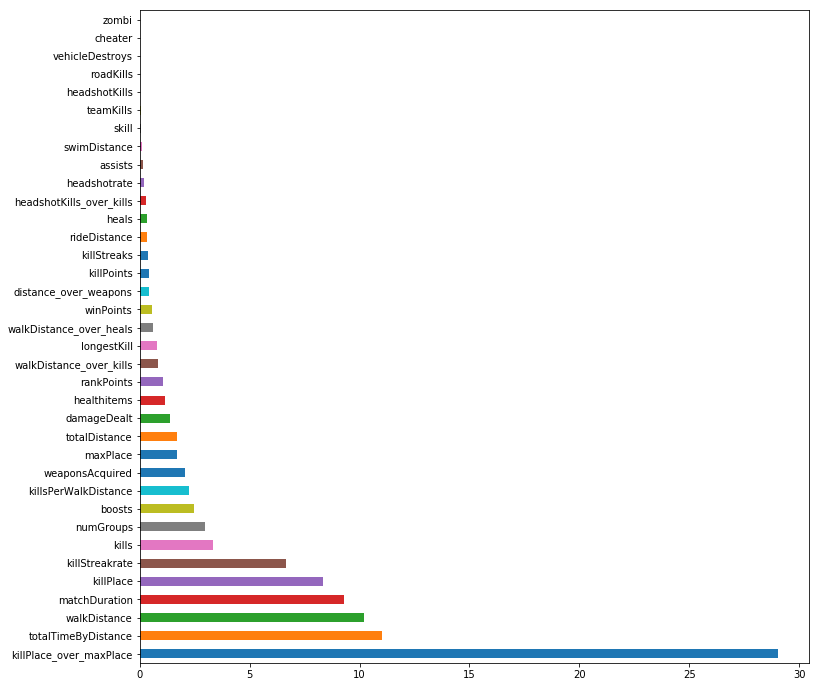

In [65]:
cat_feat_importances = pd.Series(cat_fi, index=cat_fn)
cat_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# Random forest
<!--https://www.kaggle.com/pavelvpster/pubg-random-forest-baseline !-->

In [14]:
from sklearn.ensemble import RandomForestRegressor
# X_train, X_holdout, y_train, y_holdout 
rf = RandomForestRegressor(n_estimators=3000, criterion='mse',max_depth=6,
                           min_samples_leaf=3, max_features='sqrt',
                           n_jobs=-1, verbose=True)
rf.fit(X_train, y_train)

In [14]:
rf_y_pred = rf.predict(X_holdout)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 11.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    3.

In [28]:
print("MAE: ",
mean_absolute_error(y_holdout, rf_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, rf_y_pred))

MAE:  0.06138763809018693
MSE:  0.007488019050449579


MAE:  0.06138763809018693 <br>
MSE:  0.007488019050449579 <br>
неплохо, но lightgbm лучше

In [66]:
rf_fi = rf.feature_importances_
rf_fn = X_train.columns

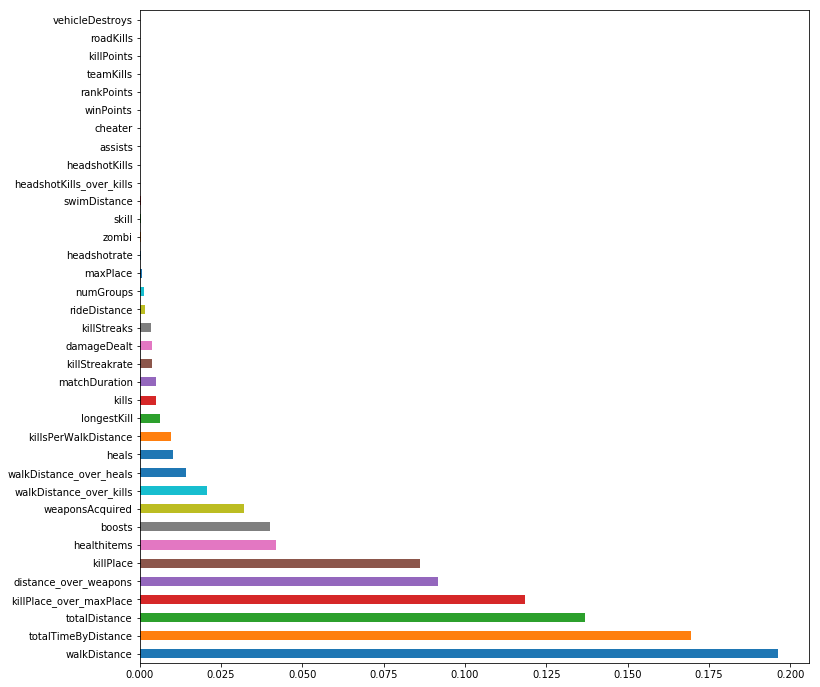

In [67]:
rf_feat_importances = pd.Series(rf_fi, index=rf_fn)
rf_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# xgboost

In [22]:
import xgboost

In [40]:
xgb_model_name = 'xgb_long'
xgb = xgboost.XGBRegressor(
    n_estimators=3000,#1650,
    max_depth=11,
    disable_default_eval_metric=1,
    
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.05,
    n_jobs=4)
if not os.path.isfile(xgb_model_name):
    xgb.fit(dev_X, dev_y,
            eval_set=[(val_X, val_y)], eval_metric='mae',
            early_stopping_rounds=200)#100)
    xgb.save_model(xgb_model_name)
else:
    xgb.load_model(xgb_model_name)

[790]	validation_0-mae:0.029152
[791]	validation_0-mae:0.029151
[792]	validation_0-mae:0.029151
[793]	validation_0-mae:0.029151
[794]	validation_0-mae:0.029152
[795]	validation_0-mae:0.029152
[796]	validation_0-mae:0.029151
[797]	validation_0-mae:0.029151
[798]	validation_0-mae:0.029151
[799]	validation_0-mae:0.029151
[800]	validation_0-mae:0.02915
[801]	validation_0-mae:0.02915
[802]	validation_0-mae:0.02915
[803]	validation_0-mae:0.02915
[804]	validation_0-mae:0.02915
[805]	validation_0-mae:0.029149
[806]	validation_0-mae:0.029149
[807]	validation_0-mae:0.02915
[808]	validation_0-mae:0.029149
[809]	validation_0-mae:0.029149
[810]	validation_0-mae:0.029148
[811]	validation_0-mae:0.029148
[812]	validation_0-mae:0.029148
[813]	validation_0-mae:0.029149
[814]	validation_0-mae:0.029149
[815]	validation_0-mae:0.029149
[816]	validation_0-mae:0.029148
[817]	validation_0-mae:0.029148
[818]	validation_0-mae:0.029148
[819]	validation_0-mae:0.029148
[820]	validation_0-mae:0.029148
[821]	validati

In [41]:
xgb_y_pred = xgb.predict(X_holdout)

In [42]:
print("MAE: ",
mean_absolute_error(y_holdout, xgb_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_y_pred))

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub,xgb_y_pred)) )


MAE:  0.028687226
MSE:  0.0017929296
MAE:  0.02846120512749597


MAE:  0.028687226
MSE:  0.0017929296
MAE:  0.02846120512749597


MAE:  0.041357085
MSE:  0.0038705154

In [30]:
xgb_cat_light_rf = (0.55*fix_pred(df_sub,xgb_y_pred) +  0.45*fix_pred(df_sub,pred_y)) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)

xgb_cat_light_rf[xgb_cat_light_rf > 1] = 1.0
xgb_cat_light_rf[xgb_cat_light_rf < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))

MAE:  0.028092680252812082
MSE:  0.0017405353407301152


MAE:  0.04086364367494448
MSE:  0.0037856299086122176

In [69]:
xgb_fi = xgb.feature_importances_
xgb_fn = X_train.columns

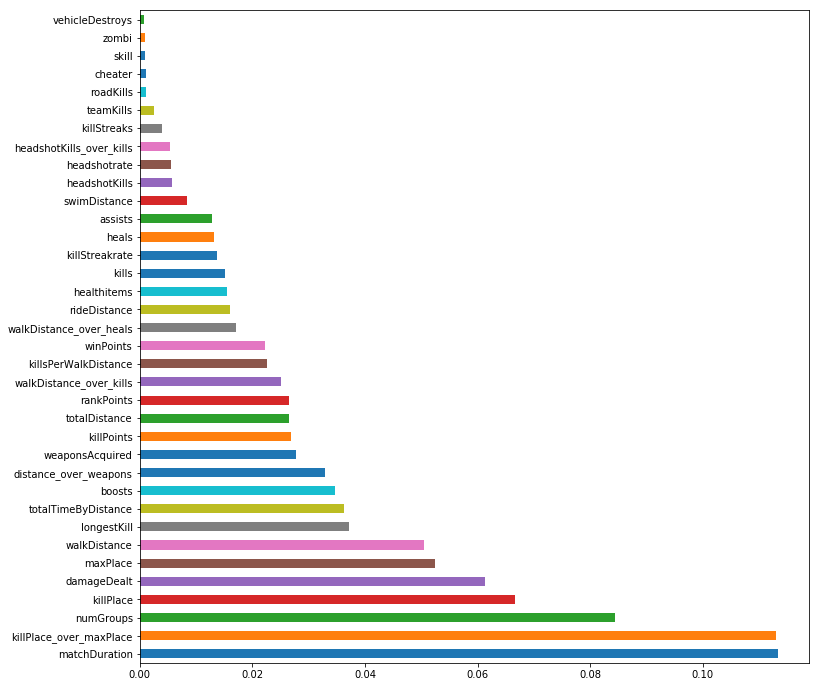

In [70]:
xgb_feat_importances = pd.Series(xgb_fi, index=xgb_fn)
xgb_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

In [39]:
xgb_cat_light = (xgb_y_pred + cat_preds + pred_y) / float(3)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light))

MAE:  0.039335084236231665
MSE:  0.0034336351784353255


In [56]:
xgb_cat_light_rf = (0.1*xgb_y_pred + 0.05*cat_preds + 0.8*pred_y + 0.05*rf_y_pred) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))

MAE:  0.03832647266547806
MSE:  0.003340634585247405


In [51]:
import itertools
all_pred = [fix_pred(df_sub, xgb_y_pred) , fix_pred(df_sub, cat_preds) ,
            fix_pred(df_sub,pred_y), fix_pred(df_sub,rf_y_pred)]

perms = [x for l in range(1, len(all_pred)) for x in itertools.combinations(all_pred, l)]

best_mae = 99
for p in perms:
    pred = sum(p) / len(p)
    
    pred = fix_pred(df_sub,pred)
    mae = mean_absolute_error(y_holdout, pred)
    print("MAE: ",
     mae)
    if mae < best_mae:
        best_mae = mae

    print("MSE: ",
    mean_squared_error(y_holdout, pred))
    print('next')
    
print("Best MAE: ",
     best_mae)

MAE:  0.039638326495077626
MSE:  0.003517461499637793
next
MAE:  0.039098391076763314
MSE:  0.0034593380562781928
next
MAE:  0.03808892469893492
MSE:  0.003330110665318027
next
MAE:  0.06105763426800979
MSE:  0.00744968323596438
next
MAE:  0.03919013169283027
MSE:  0.003452454794245993
next
MAE:  0.038550136624131495
MSE:  0.003361142035981372
next
MAE:  0.047136721207305755
MSE:  0.004572913990309611
next
MAE:  0.0383415197429545
MSE:  0.0033509825183464224
next
MAE:  0.046614265109462566
MSE:  0.004482858995409761
next
MAE:  0.04595947049671547
MSE:  0.0043680269111420165
next
MAE:  0.03856098344320775
MSE:  0.0033657636772207703
next
MAE:  0.04329008508751715
MSE:  0.003955940407203503
next
MAE:  0.04281248898249299
MSE:  0.0038718685824693138
next
MAE:  0.042541527755996435
MSE:  0.0038360855412869575
next
Best MAE:  0.03808892469893492


In [43]:
xgb_cat_light_rf = (0.55*fix_pred(df_sub,xgb_y_pred) +  0.45*fix_pred(df_sub,pred_y)) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)

xgb_cat_light_rf[xgb_cat_light_rf > 1] = 1.0
xgb_cat_light_rf[xgb_cat_light_rf < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))

MAE:  0.028092680252812082
MSE:  0.0017405353407301152
